<a href="source/Python-R+GBM.ipunb" download target="_blank">Скачать ipunb-файл можно здесь</a>

In [137]:
from class_magnesium_not_drop_na import *
class Magnesium_R(Magnesium):    
    def save_to_csv(self, data, path):
        df = pd.DataFrame(np.append(data[0], data[1].reshape(-1,1), axis=1),columns=self.features)
        df.to_csv(path, sep='\t', index=False)
    
    def do_partitions(self, n_splits = 5, ratio = 'auto'):  
        if not os.path.exists('tmp'):
            os.mkdir('tmp')
            os.mkdir('tmp/trains')
            os.mkdir('tmp/tests')
            os.mkdir('tmp/balanced_tests')
        x, y = self.x, self.y
        trains = []
        tests = []
        balanced_tests = []
        gss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
        rus = RandomUnderSampler(ratio = ratio, random_state=42)
        splitted = gss.split(x, y) 
        for i, (train_index, test_index) in enumerate(splitted):    
            x_train, y_train = rus.fit_sample(x[train_index], y[train_index])
            self.save_to_csv([x_train, y_train], 'tmp/trains/%d.csv'%(i+1))
        balanced_tests = list(rus.fit_sample(x[test_index], y[test_index]))
        self.save_to_csv(balanced_tests, 'tmp/balanced_tests/%d.csv'%(i+1))
        tests = [np.array(x[test_index]), y[test_index]]   
        self.save_to_csv(tests, 'tmp/tests/%d.csv'%(i+1))

In [138]:
m_r = Magnesium_R('set_minresol_N_5_m_m.csv', fold='../input files/')
m_r.do_partitions()

In [99]:
pd.read_table('tmp/trains/1.csv').head()

,xray,resol,chainlen,protein,alpham2,betam2,gammam2,deltam2,epsilonm2,zetam2,...,tHH2,tSS2,stem,hairpin,bulge,internal,junction,wtlen,wtnum,mg
0,1.0,2.3000,144.0,1.0,-74.5,175.0,64.3,75.6,-152.6,-64.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,3.0,1.0
1,1.0,2.4630,68.0,0.0,81.5,-119.6,67.0,142.8,-81.3,-122.6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,2.0,1.0
2,1.0,2.2000,122.0,1.0,-66.5,179.6,53.4,79.0,-133.8,-61.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,1.0
3,1.0,1.9912,86.0,0.0,-148.3,-148.3,-148.3,-148.3,-148.3,-148.3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0
4,1.0,1.8000,19.0,1.0,-66.6,173.7,47.7,78.9,-141.6,-68.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,3.0,1.0


In [2]:
import os
os.environ['R_HOME'] = 'C:\\Program Files\R\\R-3.3.2' #path to your R installation
os.environ['R_USER'] = 'C:\\Users\\tikho\\Anaconda3\\Lib\\site-packages\\rpy2'

%load_ext RWinOut
#%R install.packages("R.utils")
%R library(R.utils)


Error in contrib.url(repos, "source") : 
  trying to use CRAN without setting a mirror


array(['R.utils', 'R.oo', 'R.methodsS3', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='<U11')

In [6]:
%%R
#find best parametres
#install.packages("caret")
#install.packages("e1071", repos="http://R-Forge.R-project.org")
#library(e1071)
require(caret)
library(gbm)

path = 'tmp/trains/'

data = read.csv(paste0(path,'1.csv'), sep = '\t')
# set a grid of parameters to optimize upon;
# all these are gbm params and must be specified
gbmGrid <- expand.grid(
  n.trees = c(100, 250, 500),
  shrinkage = c(0.001, 0.01, 0.1), # lambda
  interaction.depth = c(1, 2, 4), 
  n.minobsinnode = c(1, 10) # left at default
)
 
# 5-fold CV; set method to "repeatedcv" 
# and set repeats for repeated CV
gbmTrControl <- trainControl(
  method = "cv",
  number = 5,
  verboseIter = FALSE,
  allowParallel = TRUE
)
 
# do the training
gbmTrain <- train(
  x = data[,1:dim(data)[2]-1], 
  y = factor(data$mg), 
  trControl = gbmTrControl,
  tuneGrid = gbmGrid,
  method = "gbm",
  distribution="gaussian",
  verbose = F
)
gbmTrain

package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\tikho\AppData\Local\Temp\RtmpwzzV8i\downloaded_packages
Stochastic Gradient Boosting 

1938 samples
 361 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1551, 1550, 1551, 1550, 1550 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  Accuracy   Kappa    
  0.001      1                   1              100      0.5691534  0.1383929
  0.001      1                   1              250      0.5722462  0.1445839
  0.001      1                   1              500      0.5686366  0.1373574
  0.001      1                  10              100      0.5614215  0.1230071
  0.001      1                  10              250      0.5681158  0.1363817
  0.001      1                  10              500      0.5706905  0.1414764
  0.001      2                   1              1

In [54]:
%%R
print(gbmTrain$results[as.numeric(rownames(gbmTrain$bestTune)),])
parametres = gbmTrain$results[as.numeric(rownames(gbmTrain$bestTune)),1:4]

   shrinkage interaction.depth n.minobsinnode n.trees  Accuracy     Kappa
51       0.1                 4              1     500 0.6455167 0.2910319
   AccuracySD   KappaSD
51 0.02346237 0.0469856


In [55]:
%%R
path = 'tmp/trains/'
files = list.files(path)
#install.packages(pkgs='gbm',repos="http://cran.r-project.org")
library(gbm)

model.gbm = sapply(files, function(x){
    data = read.csv(paste0(path,x), sep = '\t')
    if (x=='1.csv'){
        model.gbm_first = gbm(
              mg ~ ., data = data,
              shrinkage = parametres$shrinkage,
              n.trees = parametres$n.trees,
              interaction.depth = parametres$interaction.depth,
              n.minobsinnode = parametres$n.minobsinnode,
              cv.folds = 0,
              distribution = "gaussian", 
              verbose = T,
              keep.data = TRUE)
    }
    else {
        gbm.fit(data[,1:dim(data)[2]-1], data$mg,
                      shrinkage = parametres$shrinkage,
                      n.trees = parametres$n.trees,
                      interaction.depth = parametres$interaction.depth,
                      n.minobsinnode = parametres$n.minobsinnode,
                      distribution = "gaussian", 
                      verbose = T,
                      keep.data = TRUE)
    }
})
save(model.gbm, file="tmp/model.gbm.Rdata");
model.gbm

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.2476             nan     0.1000    0.0009
     2        0.2445             nan     0.1000    0.0020
     3        0.2421             nan     0.1000    0.0010
     4        0.2398             nan     0.1000    0.0011
     5        0.2376             nan     0.1000    0.0014
     6        0.2357             nan     0.1000    0.0008
     7        0.2340             nan     0.1000    0.0007
     8        0.2324             nan     0.1000   -0.0000
     9        0.2309             nan     0.1000    0.0003
    10        0.2291             nan     0.1000    0.0009
    20        0.2141             nan     0.1000    0.0006
    40        0.1915             nan     0.1000    0.0000
    60        0.1734             nan     0.1000   -0.0003
    80        0.1592             nan     0.1000   -0.0002
   100        0.1465             nan     0.1000   -0.0003
   120        0.1363             nan     0.1000   -0.0004
   140        

In [140]:
%%R -o predictions_prob,y
#install.packages("pROC")
#install.packages('rpart')
library(pROC)
library(rpart)

path = 'tmp/tests/'
files = list.files(path)[1]
data = read.csv(paste0(path,files), sep = '\t')

predictions_prob <- predict(object=model.gbm$'5.csv', newdata=data[1:dim(data)[2]-1], n.trees = parametres$n.trees)
y = data$mg

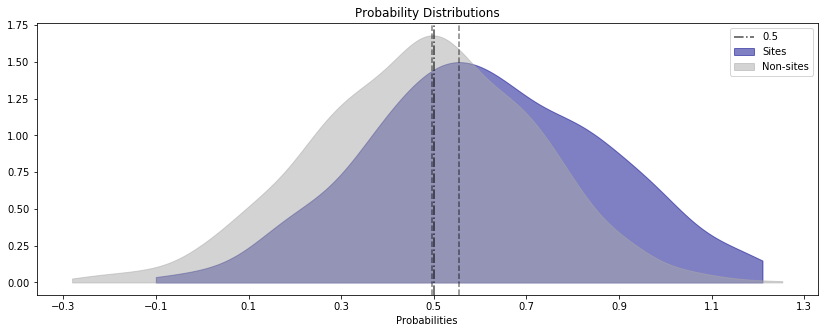

In [139]:
m_r.plot_probability_density(predictions_prob, y)
m_r.show_plots({'prob_density':m_r.probability_density_plot})
plt.xticks(np.arange(round(np.min(predictions_prob),1), round(np.max(predictions_prob)+0.2,1), 0.2))
plt.show()